### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 27 апреля 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 27 апреля, -4 балла после 08:30 4 мая, -6 баллов после 08:30 11 мая, -8 баллов после 08:30 18 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [970]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini', max_features=None):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        max_features -- максимальное число признаков на проверку в вершине
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.class_names = None
        # Для последнего задания
        self.feature_importances_ = None
        self.feature_names = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
        self.max_features = max_features
    
    def qual_func(self, p):
        if self.criterion == 'misclass':
            return  1 - max(p)
        elif self.criterion == 'gini':
            return 1 - sum(p*p)
        elif self.criterion == 'entropy':
            return sum(p * np.log2(p))
        else:
            print("use 'misclass','gini' or 'entropy' for quality function")
            raise
    
    def qual_score(self, l_y, r_y):
        # l_y - responces of left tree
        # r_y - responces of right tree
        l_n = len(l_y)
        r_n = len(r_y)

        p_v = self.__count_prob(np.hstack((l_y, r_y)))
        p_vl =  self.__count_prob(l_y)
        p_vr = self.__count_prob(r_y)

        score = self.qual_func(p_v) - self.qual_func(p_vl) * l_n/(l_n + r_n) - self.qual_func(p_vr) * r_n/(l_n + r_n)
        return score
 
    def __count_prob(self, y):
        values, counts = np.unique(y, return_counts=True)
        di = dict(zip(values, counts))
        probs=[]
        for i in self.class_names:
            if i in values:
                probs.append(di[i])
            else:
                probs.append(0)
        probs = np.array(probs) / y.shape[0]
        return probs

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
    
    def __div_samples_col(self, x, y, threshold):
        left_mask = (x > threshold)
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
    
    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        features_set = np.arange(x.shape[1])
        np.random.shuffle(features_set)
        
        # выбор признаков
        if isinstance(self.max_features, int):
            n_features = self.max_features
        elif self.max_features == 'sqrt':
            n_features = np.sqrt(self.max_features)
        elif self.max_features == 'log2':
            n_features = np.log2(self.max_features)
        elif self.max_features == None:
            n_features = x.shape[1] 
        
        best_score = -1
        best_feature = features_set[0]
        best_threshold = None #x[0, best_feature]
        
        #start = self.min_samples_split
        #end = len(y) - self.min_samples_split+1
        #t1=time.time()
        
        for feature_id in features_set[:n_features]:
            x_col = np.unique(x[:,feature_id])
            
            # отсортированные значения признаков
            #x_asort = x[:,feature_id].argsort()
            #x_col = x[:,feature_id][x_asort]#[min_samples_split:-min_samples_split] #
            #y_col = y[x_asort]#[min_samples_split:-min_samples_split] 
            
            #qual_list=np.array([self.qual_score(y[0:i],y[i:]) \
            #                 for i in range(start, end)])
            #n_cur_score = np.array(np.where(qual_list==qual_list.min())) + start
            #
            #cur_score = y_col[n_cur_score]
            
            for val in x_col:
                x_l, x_r, y_l, y_r = self.__div_samples_col(x[:,feature_id], y, val)
                SPLIT_OK = (x_l.shape[0] >= self.min_samples_split) and (x_r.shape[0] >= self.min_samples_split)
                if SPLIT_OK:
                    cur_score = self.qual_score(y_l, y_r)
                    if (best_score < cur_score):
                        best_threshold = val
                        best_score = cur_score
                        best_feature = feature_id
        
        #t2=time.time()
        #print(t2-t1)

        if best_score <= 0:
            return None, None, None
        else:
            self.feature_importances_[best_feature] += best_score
            return best_feature, best_threshold, best_score

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        p_v = self.__count_prob(y)
        #print(p_v, x.shape[0])
        
        if depth >= self.max_depth:
            IS_LEAF = True
        else:
            IS_LEAF = (x.shape[0] < 2*self.min_samples_split)
        
        if IS_LEAF:
            node_type = self.__class__.LEAF_TYPE
            resp = np.where(p_v == p_v.max())[0][0]
            self.tree[node_id] = (node_type, resp, p_v)            
        
        else:
            node_feature, node_threshold, feature_score = self.__find_threshold(x, y)
            if feature_score == None:
                node_type = self.__class__.LEAF_TYPE
                resp = np.where(p_v == p_v.max())[0][0]
                self.tree[node_id] = (node_type, resp, p_v)  
            else:
                node_type = self.__class__.NON_LEAF_TYPE
                self.tree[node_id] = (node_type, node_feature, node_threshold)

                x_left, x_right, y_left, y_right = self.__div_samples(x, y, node_feature, node_threshold)
                #print(x_left.shape[0], x_right.shape[0])

                self.__fit_node(x_left, y_left, node_id * 2 + 1, depth + 1)
                self.__fit_node(x_right, y_right, node_id * 2 + 2, depth + 1)

    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.feature_importances_ = np.zeros(x.shape[1])
        #try:
        #    self.feature_names = x.columns
        #except:
        #    self.feature_names = list(range(x.shape[0]))
        self.class_names = np.unique(y)
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            #print(feature_id, x[feature_id], threshold)
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.feature_importances_#dict(zip(self.feature_names, self.feature_importances_))

In [797]:
my_clf = MyDecisionTreeClassifier(min_samples_split=3)
clf = DecisionTreeClassifier(min_samples_split=3)

In [798]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)
pd.DataFrame(X_train).head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,13.29,1.97,2.68,16.8,102.0,3.00,3.23,0.31,1.66,6.00,1.07,2.84,1270.0
1,13.11,1.01,1.70,15.0,78.0,2.98,3.18,0.26,2.28,5.30,1.12,3.18,502.0
2,12.36,3.83,2.38,21.0,88.0,2.30,0.92,0.50,1.04,7.65,0.56,1.58,520.0


In [802]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [803]:
my_clf.fit(X_train, y_train)

In [804]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.7777777777777778
0.7777777777777778


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [805]:
%time clf.fit(X_train, y_train)

Wall time: 996 µs


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [806]:
%time my_clf.fit(X_train, y_train)

Wall time: 816 ms


Пробовал улучшать, но оказывается примерно так же.

## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


Начнём точно так же, как на семинаре.

In [807]:
df = pd.read_csv('./data/speed-dating-experiment/Speed Dating Data.csv', encoding='latin1')
df.shape

(8378, 195)

In [808]:
df=df.iloc[:,:97]
df.head(3)

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1
0,1,1.0,0,1,1,1,10,7,NaN,4,...,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN


In [809]:
df.columns

Index(['iid', 'id', 'gender', 'idg', 'condtn', 'wave', 'round', 'position',
       'positin1', 'order', 'partner', 'pid', 'match', 'int_corr', 'samerace',
       'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun',
       'pf_o_amb', 'pf_o_sha', 'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
       'amb_o', 'shar_o', 'like_o', 'prob_o', 'met_o', 'age', 'field',
       'field_cd', 'undergra', 'mn_sat', 'tuition', 'race', 'imprace',
       'imprelig', 'from', 'zipcode', 'income', 'goal', 'date', 'go_out',
       'career', 'career_c', 'sports', 'tvsports', 'exercise', 'dining',
       'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv',
       'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',
       'exphappy', 'expnum', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1',
       'amb1_1', 'shar1_1', 'attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1',
       'amb4_1', 'shar4_1', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1',
       'amb2_1', 'shar2_1', 'attr3_1', 'si

Рассмотрим нужные признаки по очереди

#### iid
unique subject number, group(wave id gender)

Кажется это идентификатор

In [810]:
df.iid.nunique()

551

#### id 

Subject number within wave

Кажется это нам не нужно

In [811]:
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)

#### gender

* Female=0
* Male=1

In [812]:
df.drop_duplicates(subset=['iid']).gender.value_counts()

1    277
0    274
Name: gender, dtype: int64

In [813]:
df.shape

(8378, 95)

#### condtn:
* 1=limited choice
* 2=extensive choice

???

In [814]:
df.drop_duplicates(subset=['iid']).condtn.value_counts()

2    386
1    165
Name: condtn, dtype: int64

In [815]:
df = df.drop(['condtn'], axis=1)

#### wave

Пока оставим в таблице, но в качестве признака рассматривать не будем

In [816]:
df.wave.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21], dtype=int64)

#### round:

number of people that met in wave

Можно взять в качестве признака.. -- значит оставим

In [817]:
df.drop_duplicates('iid')['round'].isnull().sum(), df['round'].isnull().sum()

(0, 0)

In [818]:
#df = df.drop(['round'], axis=1)

#### position:
station number where met partner 

#### positin1
station number where started 

Выкидываем

In [819]:
df = df.drop(['position', 'positin1'], axis=1)

#### order: 		
the number of date that night when met partner

Пожалуй, это может быть признаком.

In [820]:
df.drop_duplicates('iid')['order'].isnull().sum(), df['order'].isnull().sum()

(0, 0)

In [821]:
#df = df.drop(['order'], axis=1)

#### partner: 	
partner’s id number the night of event

Это можно удались

#### pid: 		
partner’s iid number
А вот это важно


In [822]:
df = df.drop(['partner'], axis=1)

##### match		
* 1=yes, 
* 0=no

Наш таргет

#### int_corr:	
correlation between participant’s and partner’s ratings of interests in 		

#### samerace:  	
participant and the partner were the same race. 1= yes, 0=no

Придумали за нас признаки)

#### age_o:		
age of partner
#### race_o:		
race of partner
#### pf_o_att: 	
partner’s stated preference at Time 1 (attr1_1) for all 6 attributes
#### dec_o: 		
decision of partner the night of event
#### attr_o: 		
rating by partner the night of the event, for all 6 attributes

Убираем

In [823]:
df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
             axis=1)

#### age
оставляем

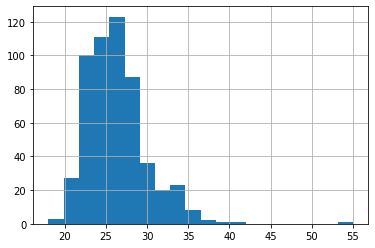

In [824]:
df.drop_duplicates(subset=['iid']).age.hist(bins=20)

In [825]:
df.drop_duplicates('iid').age.isnull().sum()

8

In [826]:
df = df.dropna(subset=['age'])
df.shape

(8283, 73)

#### field:		
field of study  

#### field_cd: 	
field coded 


In [827]:
df.field_cd.unique()

array([ 1.,  2., 13.,  8.,  5.,  9.,  3., 11., nan, 12.,  4.,  7.,  6.,
       10., 14., 16., 15., 17., 18.])

In [828]:
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)

In [829]:
df.field_cd.isnull().sum()

0

In [830]:
for i, group in df.groupby('field_cd'):
    print('=' * 10)
    print('Field Code {}'.format(i))
    print(group.field.unique())

Field Code 1.0
['Law' 'law' 'LAW' 'Law and Social Work'
 'Law and English Literature (J.D./Ph.D.)' 'Intellectual Property Law'
 'Law/Business']
Field Code 2.0
['Economics' 'Mathematics' 'Statistics' 'math' 'Mathematics, PhD' 'Stats'
 'math of finance' 'Math']
Field Code 3.0
['Psychology' 'Speech Language Pathology' 'Speech Languahe Pathology'
 'Educational Psychology' 'Organizational Psychology' 'psychology'
 'Communications' 'Sociology' 'psychology and english' 'theory'
 'Health policy' 'Clinical Psychology' 'Sociology and Education'
 'sociology' 'Anthropology/Education' 'speech pathology'
 'Speech Pathology' 'Anthropology' 'School Psychology' 'anthropology'
 'Counseling Psychology' 'African-American Studies/History']
Field Code 4.0
['Medicine' 'Art History/medicine'
 'Sociomedical Sciences- School of Public Health' 'Epidemiology'
 'GS Postbacc PreMed' 'medicine']
Field Code 5.0
['Operations Research' 'Mechanical Engineering' 'Engineering'
 'Electrical Engineering' 'Operations Researc

In [831]:
df = df.drop(['field'], axis=1)

Надо же как-то закодировать field_cd! Категориальные признаки надо разбивать на бинарные.

In [832]:
bin_field = pd.get_dummies(df.field_cd)

df = df.drop('field_cd',axis = 1)

df = df.join(bin_field)

In [833]:
df.shape

(8283, 90)

#### undergrd:  	
school attended for undergraduate degree

Пока выкинем

In [834]:
df.undergra.value_counts().head()

UC Berkeley    107
Harvard        104
Columbia        95
Yale            86
NYU             78
Name: undergra, dtype: int64

In [835]:
df = df.drop(['undergra'], axis=1)

#### mn_sat: 	
Median SAT score for the undergraduate institution where attended.  			

In [836]:
df.mn_sat.value_counts().head()

1,400.00    403
1,430.00    262
1,290.00    190
1,450.00    163
1,340.00    146
Name: mn_sat, dtype: int64

In [837]:
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)

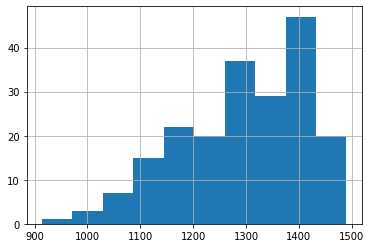

In [838]:
df.drop_duplicates('iid').mn_sat.hist()

In [839]:
df.drop_duplicates('iid').mn_sat.isnull().sum()

342

Попробуем заполнить пропущенные значения.

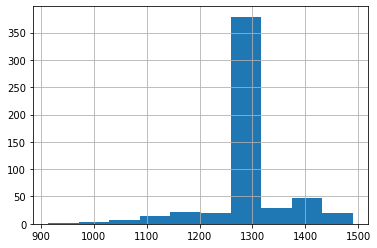

In [840]:
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].fillna(df.loc[:, 'mn_sat'].median())
df.drop_duplicates('iid').mn_sat.hist()

Понятно, что это не лучший способ, но зачастую и так работает.

#### tuition: 	
Tuition listed for each response to undergrad in Barron’s 25th Edition college profile book.

In [841]:
df.tuition.value_counts().head()

26,908.00    241
26,019.00    174
15,162.00    138
25,380.00    112
26,062.00    108
Name: tuition, dtype: int64

In [842]:
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)

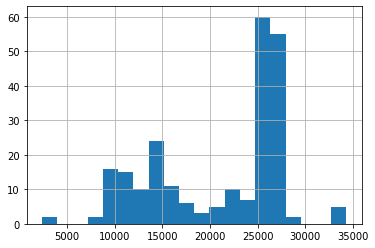

In [843]:
df.drop_duplicates('iid').tuition.hist(bins=20)

In [844]:
df.drop_duplicates('iid').tuition.isnull().sum()

310

Выборка разваливается на две группы, условно говоря, до 20000 и после. По хорошему надо бы научиться предсказывать данный признак по другим признакам. Например, с помощью метода ближайших соседей. Но мы просто попробуем заполнить так, чтобы распределение сохранилось.


In [845]:
nulls = df['tuition'].isnull()
df.loc[nulls, 'tuition'] = np.random.choice(df.loc[~nulls,'tuition'], size=sum(nulls))

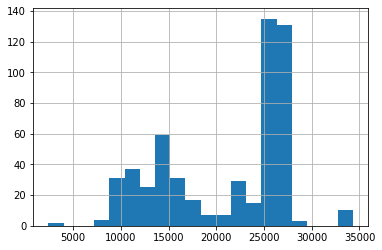

In [846]:
df.drop_duplicates('iid').tuition.hist(bins=20)

#### race:
* Black/African American=1
* European/Caucasian-American=2
* Latino/Hispanic American=3
* Asian/Pacific Islander/Asian-American=4
* Native American=5
* Other=6


Снова категориальный признак.

In [847]:
df.race.unique() # пропусков и индейцев нет

array([4., 2., 6., 3., 1.])

In [848]:
df.shape

(8283, 89)

In [849]:
df.loc[:,'race'] = 'race_' + df.race.astype('str')

In [850]:
bin_race = pd.get_dummies(df.race)
df = df.join(bin_race)

In [851]:
bin_race.head()

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [852]:
df = df.drop('race',axis = 1)

In [853]:
df.shape

(8283, 93)

#### imprace:
How important is it to you (on a scale of 1-10) that a person you date be of the same racial/ethnic background?

#### imprelig:
 How important is it to you (on a scale of 1-10) that a person you date be of the same religious background?


In [854]:
df.drop_duplicates('iid').imprace.isnull().sum()

1

In [855]:
df.drop_duplicates('iid').imprelig.isnull().sum()

1

In [856]:
# Что делать? да удалять, итак много строчек))

df = df.dropna(subset=['imprelig', 'imprace'])
df.shape

(8267, 93)

#### from:
Where are you from originally (before coming to Columbia)? 

#### zipcode:
What was the zip code of the area where you grew up? 

Выкидываем

In [857]:
df = df.drop(['from', 'zipcode'], axis=1)

#### income

In [858]:
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)

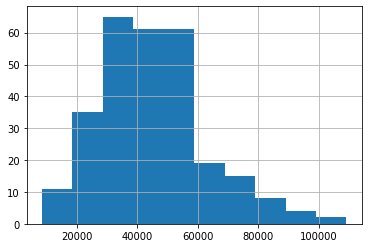

In [859]:
df.drop_duplicates('iid').loc[:, 'income'].hist()

In [860]:
df.drop_duplicates('iid').loc[:, 'income'].isnull().sum()

261

In [861]:
df = df.drop(['income'], axis=1)
# df.loc[:, 'income'] = df.loc[:, 'income'].fillna(-999)

#### goal:
    What is your primary goal in participating in this event? 
	Seemed like a fun night out=1
	To meet new people=2
	To get a date=3
	Looking for a serious relationship=4
	To say I did it=5
	Other=6

#### date:
    In general, how frequently do you go on dates? 
	Several times a week=1
	Twice a week=2
	Once a week=3
	Twice a month=4
	Once a month=5
	Several times a year=6
	Almost never=7

#### go out:
    How often do you go out (not necessarily on dates)?
	Several times a week=1
	Twice a week=2
	Once a week=3
	Twice a month=4
	Once a month=5
	Several times a year=6
	Almost never=7

Как бы вы предложили закодировать эти переменные?

goal -- категориальная переменная, остальные порядковые. В порядковых просто посмотрим на пропущенные значения.

In [862]:
df.drop_duplicates('iid').date.isnull().sum()

1

In [863]:
df = df.dropna(subset=['date'])

In [864]:
df.drop_duplicates('iid').go_out.isnull().sum()

0

Теперь разложим 'goal'.

In [865]:
df.goal.unique() # пропусков нет 

array([2., 1., 6., 3., 4., 5.])

In [866]:
df.loc[:,'goal'] = 'goal_' + df.goal.astype('str')

bin_goal = pd.get_dummies(df.goal)
df = df.join(bin_goal)
df.shape

(8249, 96)

In [867]:
df = df.drop(['goal'], axis=1)
df.shape

(8249, 95)

#### career:
What is your intended career?

#### career_c: 
career coded 

Работаем аналогично field и field_cd

In [868]:
for i, group in df.groupby('career_c'):
    print('=' * 10)
    print('Career Code {}'.format(i))
    print(group.career.unique())

Career Code 1.0
['lawyer/policy work' 'lawyer' 'Law' 'Corporate Lawyer' 'Lawyer'
 'Corporate attorney' 'law' 'Intellectual Property Attorney' 'LAWYER'
 'attorney' 'Lawyer or professional surfer' 'lawyer/gov.position'
 'Law or finance' 'IP Law' 'Academic (Law)' 'Private Equity' 'attorney?'
 'Corporate law' 'tax lawyer' 'Business/Law' 'Assistant District Attorney']
Career Code 2.0
['Academia, Research, Banking, Life' 'academics or journalism' 'Professor'
 'Academic' 'academia' 'teacher' 'industrial scientist'
 'teaching and then...' 'Professor of Media Studies'
 'Education Administration' 'Academic or Research staff'
 'University Professor' 'Research Scientist'
 'research in industry or academia' 'Teacher/Professor'
 'no idea, maybe a professor' 'a research position' 'professor' 'teaching'
 'engineering professional' 'research' 'Neuroscientist/Professor'
 'Education' 'Professor and Government Official'
 'physicist, probably academia' 'college art teacher' 'academic'
 'Research scientist,

In [869]:
df.career_c.isnull().sum()

59

In [870]:
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)

In [871]:
df.loc[:,'career_c'] = 'career_' + df.career_c.astype('str')

bin_career = pd.get_dummies(df.career_c)
bin_career.head()

,career_1.0,career_10.0,career_11.0,career_12.0,career_13.0,career_14.0,career_15.0,career_16.0,career_17.0,career_18.0,career_2.0,career_3.0,career_4.0,career_5.0,career_6.0,career_7.0,career_8.0,career_9.0
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [872]:
df = df.join(bin_career)
df.shape

(8249, 113)

In [873]:
df = df.drop(['career','career_c'], axis=1)

How interested are you in the following activities, on a scale of 1-10?
    
    sports: Playing sports/ athletics
    tvsports: Watching sports
    excersice: Body building/exercising
    dining: Dining out
    museums: Museums/galleries
    art: Art
    hiking:  Hiking/camping
    gaming: Gaming
    clubbing: Dancing/clubbing
    reading: Reading
    tv: Watching TV
    theater: Theater
    movies: Movies
    concerts: Going to concerts
    music: Music
    shopping: Shopping
    yoga: Yoga/meditation

По большому счету с этими признаками можно придумать много чего.. Например у нас уже есть признак, который считает корреляцию между интересами пар. Пока мы все их выкинем

In [874]:
df.loc[:, ['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga']
      ].isnull().sum()

sports      0
tvsports    0
exercise    0
dining      0
museums     0
art         0
hiking      0
gaming      0
clubbing    0
reading     0
tv          0
theater     0
movies      0
concerts    0
music       0
shopping    0
yoga        0
dtype: int64

In [875]:
df = df.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)

In [876]:
df.shape

(8249, 94)

#### exphappy:
Overall, on a scale of 1-10, how happy do you expect to be with the people you meet 
during the speed-dating event?

#### expnum: 
Out of the 20 people you will meet, how many do you expect will be interested in dating you? 


In [877]:
df.drop_duplicates('iid').exphappy.isnull().sum()

0

In [878]:
df.drop_duplicates('iid').expnum.isnull().sum()

416

In [879]:
df = df.drop(['expnum'], axis=1)

### Attr1

We want to know what you look for in the opposite sex. 
Waves 6-9: Please rate the importance of the following attributes in a potential date on a scale of 1-10 (1=not at all important, 10=extremely important):
Waves 1-5, 10-21: You have 100 points to distribute among the following attributes -- give more points to those attributes that are more important in a potential date, and fewer points to those attributes that are less important in a potential date.  Total points must equal 100.

attr1_1 
Attractive

sinc1_1
Sincere

intel1_1
Intelligent

fun1_1
Fun

amb1_1
Ambitious

shar1_1
Has shared interests/hobbies


In [880]:
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

In [881]:
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]

In [882]:
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

In [883]:
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 99)

In [884]:
temp.loc[idx, ]

,iid,wave,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,totalsum
918,67,3,20.0,15.0,20.0,20.0,5.0,10.0,90.0
1530,105,4,30.0,15.0,20.0,20.0,0.0,5.0,90.0
7221,489,19,20.0,10.0,20.0,20.0,20.0,0.0,90.0
7586,517,21,15.0,20.0,20.0,20.0,5.0,10.0,90.0
7784,526,21,10.0,10.0,30.0,20.0,10.0,15.0,95.0


In [885]:
idx = ((temp.wave >= 6) & (temp.wave <= 9))

In [886]:
temp.loc[idx, ]

,iid,wave,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,totalsum
1846,132,6,16.67,16.67,16.67,16.67,16.67,16.67,100.02
1851,133,6,12.77,19.15,17.02,17.02,14.89,19.15,100.00
1856,134,6,6.67,20.00,20.00,17.78,20.00,15.56,100.01
1861,135,6,18.18,22.73,18.18,13.64,13.64,13.64,100.01
1871,137,6,17.39,17.39,15.22,17.39,13.04,19.57,100.00
...,...,...,...,...,...,...,...,...,...
3308,229,9,21.43,16.67,21.43,16.67,11.90,11.90,100.00
3328,230,9,23.81,23.81,23.81,23.81,2.38,2.38,100.00
3348,231,9,18.60,20.93,23.26,23.26,2.33,11.63,100.01
3368,232,9,17.78,17.78,17.78,17.78,13.33,15.56,100.01


Ну понятно, надо чутка подредактировать исходные признаки и в бой

In [887]:
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)

In [888]:
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
df.shape

(8249, 94)

Проведите аналогичную работу для признаков `attr2`

### Attr2

In [889]:
feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']

In [890]:
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]

In [891]:
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

In [892]:
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 90) & (temp.totalsum != 0)

In [893]:
temp.loc[idx, ]

,iid,wave,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,totalsum
4816,320,12,20.0,10.0,10.0,10.0,20.0,10.0,80.0


In [894]:
idx = ((temp.wave >= 6) & (temp.wave <= 9))

In [895]:
temp.loc[idx, ]

,iid,wave,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,totalsum
1846,132,6,22.73,15.91,13.64,15.91,13.64,18.18,100.01
1851,133,6,24.32,16.22,13.51,16.22,10.81,18.92,100.00
1856,134,6,20.51,15.38,12.82,20.51,12.82,17.95,99.99
1861,135,6,18.75,16.67,14.58,18.75,18.75,12.50,100.00
1871,137,6,14.89,17.02,17.02,17.02,14.89,19.15,99.99
...,...,...,...,...,...,...,...,...,...
3308,229,9,15.22,19.57,15.22,17.39,21.74,10.87,100.01
3328,230,9,16.67,16.67,16.67,16.67,16.67,16.67,100.02
3348,231,9,18.18,11.36,15.91,18.18,20.45,15.91,99.99
3368,232,9,19.15,17.02,17.02,17.02,14.89,14.89,99.99


In [896]:
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)

In [897]:
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

In [898]:
df = df.drop(['temp_totalsum'], axis=1)

Признаки `attr4` и `attr5` пока выбросим

In [899]:
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)

Теперь создалим таблицу с мужчинами, таблицу с женщинами с сджоиним их

In [900]:
df.shape

(8249, 82)

In [901]:
df = df.drop(['wave'], axis=1)

In [902]:
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid', 'pid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        
df_female.columns = df_female.columns.astype('str') + '_f'

Пробовал не указывать 'pid' в drop_dublicates, как это делали на практике. Но тогда join выдаёт что-то невразумительное. Пожалуй, merge, лучше.

Пришлось сначала сделать названия колонок строками(

In [903]:
df_male.shape, df_female.shape

((4051, 80), (4073, 77))

In [904]:
df_female = df_female.rename(columns={'pid_f': 'iid', 'iid_f': 'pid'})

In [905]:
type(df_female.iid), type(df_male.iid)

(pandas.core.series.Series, pandas.core.series.Series)

In [906]:
type(list(df_male.iid)[0]), type(df_female.iid[0]) #я не понимаю, какого чёрта к женской таблице 
                                                   #можно обратиться по номеру, а к мужской только через values или list

(int, numpy.float64)

In [907]:
type(list(df_male.pid)[0]), type(df_female.pid[0]) 

(float, numpy.int64)

In [908]:
df_male['pid'] = df_male['pid'].astype('int')

In [909]:
df_merged = pd.merge(df_male, df_female, on=['iid','pid'])#df_male.join(df_female.set_index('iid'), on='iid')

In [910]:
df_merged.head(5)

,iid,round,order,pid,match,int_corr,samerace,age,mn_sat,tuition,...,career_17.0_f,career_18.0_f,career_2.0_f,career_3.0_f,career_4.0_f,career_5.0_f,career_6.0_f,career_7.0_f,career_8.0_f,career_9.0_f
0,11,10,4,1,0,0.14,0,27.0,1310.0,27395.0,...,0,1,0,0,0,0,0,0,0,0
1,11,10,10,2,0,0.29,1,27.0,1310.0,25425.0,...,0,1,0,0,0,0,0,0,0,0
2,11,10,6,3,0,-0.24,1,27.0,1310.0,22481.0,...,0,1,0,0,0,0,0,0,0,0
3,11,10,3,4,0,-0.18,1,27.0,1310.0,9451.0,...,0,0,0,0,0,0,0,0,0,0
4,11,10,1,5,0,-0.43,1,27.0,1310.0,26908.0,...,0,0,0,0,0,0,0,0,0,0


In [911]:
df_merged.shape

(3999, 155)

В полученной таблице iid -- идентификатор мужчины, pid -- идентификатор женщины 

Долго обрабатывали, поэтому

In [912]:
df_merged.to_csv('data/Speed_datind_merged.csv')

In [913]:
sum(df_merged['match'].isna())

0

Подготавливаемся к классификации

In [914]:
target = df_merged['match']
data = df_merged.drop(['match'], axis=1)

In [915]:
X_train, X_test, y_train, y_test = train_test_split(np.array(data), np.array(target), 
                                                    test_size=0.2, stratify = target)

In [916]:
clf = DecisionTreeClassifier(min_samples_split=2)
my_clf = MyDecisionTreeClassifier(min_samples_split=2)

In [917]:
%time clf.fit(X_train, y_train)

Wall time: 120 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [918]:
%time my_clf.fit(X_train, y_train)

Wall time: 6.08 s


In [919]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.7375
0.83375


Фух, работает

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [920]:
args = np.arange(2,50)
res=[]
for i in args:
    my_clf = MyDecisionTreeClassifier(min_samples_split=i)
    my_clf.fit(X_train, y_train)
    res.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
print(dict(zip(args,res)))

{2: 0.835, 3: 0.835, 4: 0.835, 5: 0.8325, 6: 0.83875, 7: 0.8375, 8: 0.8375, 9: 0.8375, 10: 0.84, 11: 0.84, 12: 0.84, 13: 0.84, 14: 0.84, 15: 0.83875, 16: 0.83875, 17: 0.83875, 18: 0.83875, 19: 0.83375, 20: 0.83375, 21: 0.83375, 22: 0.8375, 23: 0.8375, 24: 0.8375, 25: 0.8375, 26: 0.8375, 27: 0.8375, 28: 0.8375, 29: 0.8375, 30: 0.8375, 31: 0.835, 32: 0.835, 33: 0.835, 34: 0.835, 35: 0.835, 36: 0.835, 37: 0.835, 38: 0.835, 39: 0.835, 40: 0.835, 41: 0.835, 42: 0.835, 43: 0.835, 44: 0.835, 45: 0.83625, 46: 0.83625, 47: 0.83625, 48: 0.83625, 49: 0.83625}


(10, 0.84)

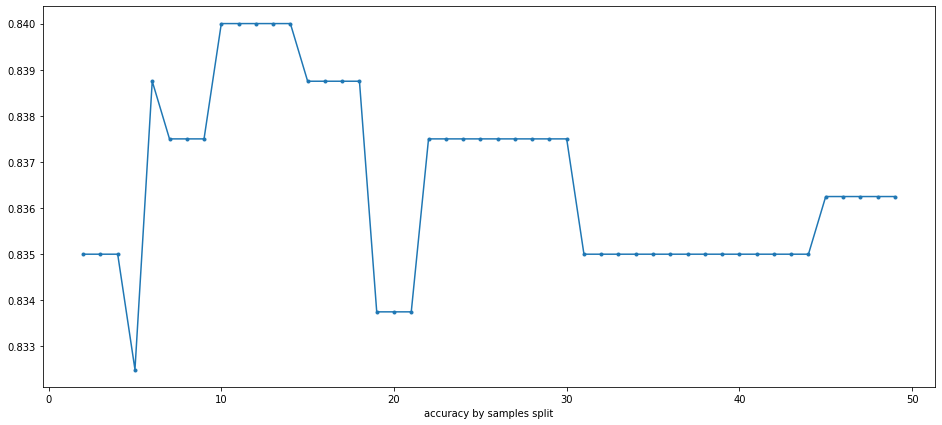

In [921]:
plt.figure(figsize=(16, 7))
plt.plot(args,res,marker = '.')
plt.xlabel('accuracy by samples split')
di = dict(zip(args,res))
max(di, key=di.get), max(res)

In [922]:
args = np.arange(2,10)
res=[]
for i in args:
    my_clf = MyDecisionTreeClassifier(max_depth=i)
    my_clf.fit(X_train, y_train)
    res.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
    print(i,' ',res)
#print(dict(zip(args,res)))

2   [0.835]
3   [0.835, 0.83625]
4   [0.835, 0.83625, 0.83375]
5   [0.835, 0.83625, 0.83375, 0.83375]
6   [0.835, 0.83625, 0.83375, 0.83375, 0.83375]
7   [0.835, 0.83625, 0.83375, 0.83375, 0.83375, 0.82]
8   [0.835, 0.83625, 0.83375, 0.83375, 0.83375, 0.82, 0.82125]
9   [0.835, 0.83625, 0.83375, 0.83375, 0.83375, 0.82, 0.82125, 0.81375]


При неправильном выборе split мы просто отделяем малое количество вершин и получаем переобученное правило. (по умолчанию split=2)

Выберем split=12, он посередине плато с наилучшими значениями.

In [925]:
args = np.arange(2,10)
res=[]
for i in args:
    my_clf = MyDecisionTreeClassifier(max_depth=i, min_samples_split=12)
    my_clf.fit(X_train, y_train)
    res.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
    print(i,' ',res)

2   [0.835]
3   [0.835, 0.83625]
4   [0.835, 0.83625, 0.8375]
5   [0.835, 0.83625, 0.8375, 0.84]
6   [0.835, 0.83625, 0.8375, 0.84, 0.84]
7   [0.835, 0.83625, 0.8375, 0.84, 0.84, 0.82]
8   [0.835, 0.83625, 0.8375, 0.84, 0.84, 0.82, 0.825]
9   [0.835, 0.83625, 0.8375, 0.84, 0.84, 0.82, 0.825, 0.81875]


(5, 0.84)

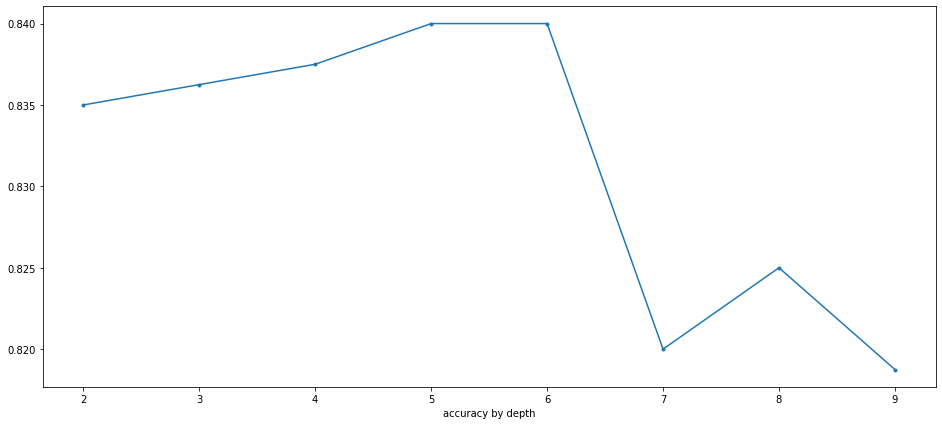

In [926]:
plt.figure(figsize=(16, 7))
plt.plot(args,res,marker = '.')
plt.xlabel('accuracy by depth')
di = dict(zip(args,res))
max(di, key=di.get), max(res)

В данном случае нам не нужна большая глубина дерева -- быстро переобучаемся. Маленький сплит способствует ускорению переобучения.

Есть смысл остановиться на split=12, depth=5. 

Точность: 0.84

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [971]:
my_clf = MyDecisionTreeClassifier(max_depth=5, min_samples_split=12)
my_clf.fit(X_train, y_train)

clf = MyDecisionTreeClassifier(max_depth=5, min_samples_split=12)
clf.fit(X_train, y_train)

In [974]:
importance_my = my_clf.get_feature_importance()

In [975]:
importance_my[1:20]

array([0.        , 0.        , 0.        , 0.00645984, 0.        ,
       0.07857505, 0.        , 0.        , 0.00147946, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01944444, 0.        , 0.        ])

In [976]:
my_features_sorted = np.argsort(importance_my)[::-1]
bib_features_sorted = np.argsort(clf.feature_importances_)[::-1]

In [977]:
df_features = pd.DataFrame([
                            data.columns[my_features_sorted],
                            importance_my[my_features_sorted],
                            data.columns[bib_features_sorted],
                            clf.feature_importances_[bib_features_sorted]
                            ],
                            index = [ "my_features", "feature importace", "sklearn features", "feature importance"]).T

In [978]:
df_features.head(10)

,my_features,feature importace,sklearn features,feature importance
0,order_f,0.154346,order,0.0892422
1,age,0.078575,age,0.078575
2,goal_1.0_f,0.0740741,goal_1.0_f,0.0740741
3,sinc2_1,0.0725652,sinc2_1,0.0725652
4,tuition_f,0.0693106,tuition_f,0.0693106
5,iid,0.0358201,order_f,0.0651042
6,amb3_1_f,0.0220858,iid,0.0358201
7,fun1_1,0.0194444,amb3_1_f,0.0220858
8,sinc2_1_f,0.0142558,fun1_1,0.0194444
9,attr2_1,0.0112184,sinc2_1_f,0.0142558


Почти все признаки совпали.
Большая зависимость от количества партнёров за вечер может объясняться ограниченным количеством match'ей. Age и goal -- абсолятно логично, если возраст и цели совпадают (отличаются интерпретируемым способом), то люди пытаются встречаться дальше.
Единственное удивление iid. Однако это объясняется зависимостью от времени (больший iid -- другие даты свиданий). Вполне возможно развитие событий, при котором людям уже не до свиданий.

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



Очень бы хотелось посмотреть не скоростное решение. Пробовал по всякому, но сильно быстрее чем здесь -- не вышло